In [1]:
from pathlib import Path

PROJECT_ROOT_DIR = str(Path.cwd().parent)
PROJECT_ROOT_DIR

'/root/llm_graph_embedder'

# Load evaluation data

In [2]:
import pandas as pd

test_data = pd.read_parquet(f"{PROJECT_ROOT_DIR}/dataset/test.parquet").sample(
    n=4000, random_state=0
)

In [3]:
def format_test_conversations(sample):
    prompt_template = """<human>: {human_turn}\n\n<gpt>:"""

    return prompt_template.format(
        human_turn=sample["formatted_conversations"][0]["value"],
        gpt_turn=sample["formatted_conversations"][1]["value"],
    )

In [4]:
test_data["full_conversation"] = test_data.apply(format_test_conversations, axis=1)

In [5]:
from datasets import DatasetDict, Dataset

dataset = DatasetDict(
    {
        "test": Dataset.from_pandas(
            test_data[["full_conversation"]].reset_index(drop=True)
        ),
    }
)

In [6]:
dataset

DatasetDict({
    test: Dataset({
        features: ['full_conversation'],
        num_rows: 4000
    })
})

# Load competitor model

## Loading fine-tuned model as `AutoModel`

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel

model_path = f"{PROJECT_ROOT_DIR}/model/graph_embedder"

tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    local_files_only=True,
)

model = AutoModel.from_pretrained(
    model_path,
    local_files_only=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading adapter weights from /root/llm_graph_embedder/model/graph_embedder led to unexpected keys not found in the model: model.layers.0.mlp.down_proj.lora_A.default.weight, model.layers.0.mlp.down_proj.lora_B.default.weight, model.layers.0.mlp.gate_proj.lora_A.default.weight, model.layers.0.mlp.gate_proj.lora_B.default.weight, model.layers.0.mlp.up_proj.lora_A.default.weight, model.layers.0.mlp.up_proj.lora_B.default.weight, model.layers.0.self_attn.k_proj.lora_A.default.weight, model.layers.0.self_attn.k_proj.lora_B.default.weight, model.layers.0.self_attn.o_proj.lora_A.default.weight, model.layers.0.self_attn.o_proj.lora_B.default.weight, model.layers.0.self_attn.q_proj.lora_A.default.weight, model.layers.0.self_attn.q_proj.lora_B.default.weight, model.layers.0.self_attn.v_proj.lora_A.default.weight, model.layers.0.self_attn.v_proj.lora_B.default.weight, model.layers.1.mlp.down_proj.lora_A.default.weight, model.layers.1.mlp.down_proj.lora_B.default.weight, model.layers.1.mlp.gate_pr

In [8]:
model.to("cuda")
model.eval()

Gemma2Model(
  (embed_tokens): Embedding(256000, 2304, padding_idx=0)
  (layers): ModuleList(
    (0-25): 26 x Gemma2DecoderLayer(
      (self_attn): Gemma2Attention(
        (q_proj): lora.Linear(
          (base_layer): Linear(in_features=2304, out_features=2048, bias=False)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default): Linear(in_features=2304, out_features=8, bias=False)
          )
          (lora_B): ModuleDict(
            (default): Linear(in_features=8, out_features=2048, bias=False)
          )
          (lora_embedding_A): ParameterDict()
          (lora_embedding_B): ParameterDict()
          (lora_magnitude_vector): ModuleDict()
        )
        (k_proj): lora.Linear(
          (base_layer): Linear(in_features=2304, out_features=1024, bias=False)
          (lora_dropout): ModuleDict(
            (default): Identity()
          )
          (lora_A): ModuleDict(
            (default)

# Generating embeddings

In [9]:
def generate_embeddings(sample):
    # Tokenize the input sentences
    inputs = tokenizer(
        sample, padding=True, truncation=True, max_length=500, return_tensors="pt"
    )

    # Move inputs to GPU if available
    device = torch.device("cuda")
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state
        # Pooling: Mean pooling over the sequence length
        embeddings = hidden_states.mean(dim=1)

    # Convert embeddings to CPU and numpy for storage
    return embeddings.cpu().numpy()

In [10]:
test_data["embeddings"] = test_data[["full_conversation"]].map(generate_embeddings)

The 'batch_size' argument of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'max_batch_size' argument instead.
The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


CPU times: user 7min 15s, sys: 2min 39s, total: 9min 54s
Wall time: 9min 54s


In [11]:
test_data

,paper_id,title,abstract,publishing_year,label,id,graph,conversations,node_idx,formatted_conversations,full_conversation,embeddings
node_idx,,,,,,,,,,,,
130928,3008777928,imprecise probability for multiparty session t...,In this paper we introduce imprecise probabili...,2020,2,arxiv_test_130928,"{'edge_index': [[1, 2, 3, 0, 4], [0, 1, 1, 1, ...","[{'from': 'human', 'value': 'Given a citation ...",130928,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.8063366, -0.45969632, -0.30506027, 0.02713..."
60877,2974840592,a review of tracking prediction and decision m...,This literature review focuses on three import...,2019,24,arxiv_test_60877,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",60877,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.4036815, -0.3611251, -0.54885393, -0.76783..."
118999,3006100229,finding all global minimum cuts in practice,We present a practically efficient algorithm t...,2020,34,arxiv_test_118999,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",118999,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.237873, -0.49409857, -0.30592087, -0.87017..."
63099,2936695845,bertscore evaluating text generation with bert,"We propose BERTScore, an automatic evaluation ...",2019,30,arxiv_test_63099,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",63099,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.3044186, -0.44861355, -0.5987033, -0.73792..."
125358,2952916454,model free data driven methods in mechanics ma...,This paper presents an integrated model-free d...,2019,7,arxiv_test_125358,"{'edge_index': [[1, 0, 2], [0, 1, 1]], 'node_i...","[{'from': 'human', 'value': 'Given a citation ...",125358,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.58410937, -0.2944254, -0.18306637, -0.0865..."
...,...,...,...,...,...,...,...,...,...,...,...,...
47595,2971443202,densepoint learning densely contextual represe...,"Point cloud processing is very challenging, as...",2019,16,arxiv_test_47595,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",47595,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.3638309, -0.46149927, -0.5704091, -0.77273..."
100021,2947514303,theoretical and experimental analysis on the g...,There is emerging interest in performing regre...,2019,24,arxiv_test_100021,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",100021,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[0.9367366, -0.37969434, -0.02273317, -0.5498..."
150716,2973251779,cnn based rgb d salient object detection learn...,The goal of this work is to present a systemat...,2019,16,arxiv_test_150716,"{'edge_index': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10...","[{'from': 'human', 'value': 'Given a citation ...",150716,"[{'from': 'human', 'value': 'Given a citation ...",<human>: Given a citation graph: \n{'edge_inde...,"[[1.4906139, -0.43694827, -0.5700801, -0.77922..."


# Visualizing embeddings

In [12]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import random


def plot_embeddings(x_vals, y_vals, labels):
    random.seed(0)

    # Generate 40 distinct colors using a custom colormap
    cmap = ListedColormap(
        plt.cm.tab20(np.linspace(0, 1, 20)).tolist() * 2
    )  # Extends tab20 to 40 colors

    plt.figure(figsize=(12, 12))

    scatter = plt.scatter(
        x_vals,
        y_vals,
        c=labels,
        cmap=cmap,  # Custom colormap with 40 colors
        s=10,  # Adjust size of points
        alpha=0.8,  # Transparency
    )

    # Add a colorbar to show the mapping of colors to classes
    cbar = plt.colorbar(scatter, ticks=np.arange(0, 40, step=1))
    cbar.set_label("Classes")
    plt.title("2D Embedding Visualization with Class Colors")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

In [13]:
from umap.umap_ import UMAP


def reduce_dimensions(values):
    vectors = np.asarray(values)

    reducer = UMAP()
    reducer.fit(vectors)
    vectors = reducer.transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals

In [14]:
%%time

x_coord, y_coord = reduce_dimensions(np.vstack(test_data["embeddings"].values))

/root/llm_graph_embedder/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 26.4 s, sys: 523 ms, total: 26.9 s
Wall time: 18.7 s


/root/llm_graph_embedder/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


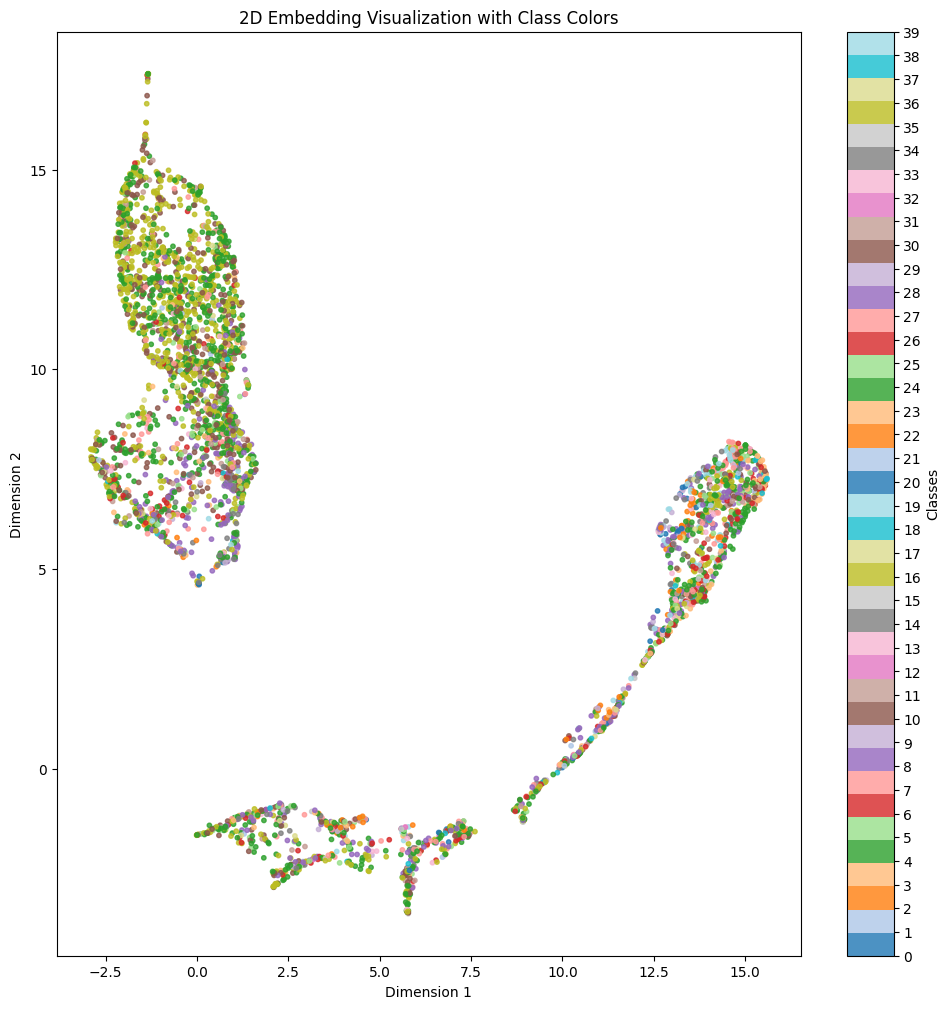

In [15]:
plot_embeddings(x_coord, y_coord, test_data["label"].values)